In [1]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials
using Statistics
using StatsPlots


┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/somrita/.julia/packages/CUDAdrv/3EzC1/src/CUDAdrv.jl:69


# Helper functions

## Main GuSTO function

In [2]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

## Function to check if inside obstacle

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

## Reading and writing to files

In [4]:
function getXYValid(filename)
    f = h5open(filename,"r")
    X_valid_norm = read(f["X_valid_norm"])
    Y_valid_norm = read(f["Y_valid_norm"])
    close(f)
    return (X_valid_norm, Y_valid_norm) 
end


getXYValid (generic function with 1 method)

In [5]:
function getDataParamsFromHDF5Combo(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return (xMin, yMin, xRange, yRange) 
end

getDataParamsFromHDF5Combo (generic function with 1 method)

## Get model on which data was collected and training done

In [6]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 5.0 # TODO CHANGED was 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [7]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

## NN helper functions

In [8]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [9]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [10]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [11]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [12]:
function getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin, yMin, xRange, yRange)  
end

getNNStructureCombo (generic function with 1 method)

In [13]:
function getNNPredictionCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin, yRange)
    return (X_soln, U_soln)
end

getNNPredictionCombo (generic function with 1 method)

# Compare cold start and warm start GuSTO performance

### Collect the iteration number and times for each

In [14]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

cold_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time]

warm_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time]

NN_run_data = zeros(size(X_valid_norm,1),1)
# NOTE: NN_run_data[row,:] = NN_solve_time

for row in 1:size(X_valid_norm,1)
# for row in 3:4
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time]
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time]
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")

#     plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])

    
    
    
#     # NN prediction time and trajectory
#     NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
# #     @show size(NN_coeffs)

#     # For the Y_valid_norm, these are 95 coefficients
#     y_v_norm = Y_valid_norm[row,:] # size 95
#     # First convert to Y_valid
#     (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
#     true_coeffs = y_v_norm.*yRange + yMin
# #     @show size(true_coeffs)

#     for dim in 1:(x_dim+u_dim)
#         true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         true_coeffs_matrix[row,dim,:] = true_cf_this
#         NN_coeffs_matrix[row,dim,:] = NN_cf_this
#     end
    if mod(row,10) == 0
        @save "coldstartwarmstartdataAdjusted.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "coldstartwarmstartdataAdjusted.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

row = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

GuSTO solve time = 36.533114983 (8 iterations)
NN_solve_time = 3.37882566
GuSTO warm started solve time = 6.492320536 (11 iterations)

row = 2
GuSTO solve time = 4.252091639 (8 iterations)
NN_solve_time = 0.002097463
GuSTO warm started solve time = 3.954167501 (7 iterations)

row = 3
GuSTO solve time = 3.084802644 (5 iterations)
NN_solve_time = 0.001933763
GuSTO warm started solve time = 3.594957431 (5 iterations)

row = 4
GuSTO solve time = 2.902977438 (5 iterations)
NN_solve_time = 0.002447756
GuSTO warm started solve time = 2.642460365 (5 iterations)

row = 5
GuSTO solve time = 2.746397726 (5 i

GuSTO solve time = 2.920134057 (5 iterations)
NN_solve_time = 0.002153858
GuSTO warm started solve time = 2.739133592 (5 iterations)

row = 56
GuSTO solve time = 9.049764661 (15 iterations)
NN_solve_time = 0.002378297
GuSTO warm started solve time = 5.611743693 (9 iterations)

row = 57
GuSTO solve time = 2.83857148 (5 iterations)
NN_solve_time = 0.00211567
GuSTO warm started solve time = 3.04197369 (5 iterations)

row = 58
GuSTO solve time = 2.498393383 (5 iterations)
NN_solve_time = 0.001875649
GuSTO warm started solve time = 2.767611232 (5 iterations)

row = 59
GuSTO solve time = 3.37500537 (5 iterations)
NN_solve_time = 0.002657589
GuSTO warm started solve time = 3.278307131 (5 iterations)

row = 60
GuSTO solve time = 2.916683134 (5 iterations)
NN_solve_time = 0.001975281
GuSTO warm started solve time = 2.557142604 (5 iterations)

Intermediate save

row = 61
GuSTO solve time = 4.517133501 (7 iterations)
NN_solve_time = 0.011165616
GuSTO warm started solve time = 3.210939077 (5 itera

GuSTO warm started solve time = 3.789450667 (6 iterations)

row = 112
GuSTO solve time = 2.796200361 (5 iterations)
NN_solve_time = 0.002296015
GuSTO warm started solve time = 2.735404936 (5 iterations)

row = 113
GuSTO solve time = 2.787173214 (5 iterations)
NN_solve_time = 0.002078529
GuSTO warm started solve time = 2.556678762 (5 iterations)

row = 114
GuSTO solve time = 13.363177385 (21 iterations)
NN_solve_time = 0.002018188
GuSTO warm started solve time = 9.531345847 (16 iterations)

row = 115
GuSTO solve time = 2.457814187 (5 iterations)
NN_solve_time = 0.001992262
GuSTO warm started solve time = 2.757867941 (5 iterations)

row = 116
GuSTO solve time = 8.250317227 (14 iterations)
NN_solve_time = 0.002190376
GuSTO warm started solve time = 11.190895855 (18 iterations)

row = 117
GuSTO solve time = 3.119334477 (5 iterations)
NN_solve_time = 0.003168865
GuSTO warm started solve time = 2.999048938 (5 iterations)

row = 118
GuSTO solve time = 2.897659179 (5 iterations)
NN_solve_time 

GuSTO warm started solve time = 2.991195891 (5 iterations)

row = 168
GuSTO solve time = 3.704164289 (7 iterations)
NN_solve_time = 0.003945828
GuSTO warm started solve time = 3.623879407 (6 iterations)

row = 169
GuSTO solve time = 10.793415325 (18 iterations)
NN_solve_time = 0.002487042
GuSTO warm started solve time = 5.729394058 (9 iterations)

row = 170
GuSTO solve time = 3.574870839 (6 iterations)
NN_solve_time = 0.002508312
GuSTO warm started solve time = 4.097662531 (7 iterations)

Intermediate save

row = 171
GuSTO solve time = 3.134669621 (5 iterations)
NN_solve_time = 0.002656926
GuSTO warm started solve time = 3.093645235 (5 iterations)

row = 172
GuSTO solve time = 2.569638171 (5 iterations)
NN_solve_time = 0.002155715
GuSTO warm started solve time = 2.885914931 (5 iterations)

row = 173
GuSTO solve time = 3.714221203 (7 iterations)
NN_solve_time = 0.002808917
GuSTO warm started solve time = 5.475182092 (9 iterations)

row = 174
GuSTO solve time = 7.435418442 (13 iterations

GuSTO warm started solve time = 3.346084255 (5 iterations)

row = 224
GuSTO solve time = 2.84212553 (5 iterations)
NN_solve_time = 0.009511376
GuSTO warm started solve time = 2.914528223 (5 iterations)

row = 225
GuSTO solve time = 8.192133449 (13 iterations)
NN_solve_time = 0.002257903
GuSTO warm started solve time = 7.504650116 (13 iterations)

row = 226
GuSTO solve time = 2.813716898 (5 iterations)
NN_solve_time = 0.002073838
GuSTO warm started solve time = 2.814229434 (5 iterations)

row = 227
GuSTO solve time = 2.75004807 (5 iterations)
NN_solve_time = 0.002136815
GuSTO warm started solve time = 2.581391649 (5 iterations)

row = 228
GuSTO solve time = 3.158097832 (5 iterations)
NN_solve_time = 0.009456264
GuSTO warm started solve time = 2.885808104 (5 iterations)

row = 229
GuSTO solve time = 3.940895179 (7 iterations)
NN_solve_time = 0.002175259
GuSTO warm started solve time = 5.495887396 (9 iterations)

row = 230
GuSTO solve time = 2.930441462 (5 iterations)
NN_solve_time = 0.00

GuSTO warm started solve time = 2.905860315 (5 iterations)

row = 280
GuSTO solve time = 4.393418125 (8 iterations)
NN_solve_time = 0.002161832
GuSTO warm started solve time = 3.478803274 (6 iterations)

Intermediate save

row = 281
GuSTO solve time = 2.782484653 (5 iterations)
NN_solve_time = 0.00227143
GuSTO warm started solve time = 3.637531011 (6 iterations)

row = 282
GuSTO solve time = 3.028658712 (5 iterations)
NN_solve_time = 0.002056911
GuSTO warm started solve time = 2.769317768 (5 iterations)

row = 283
GuSTO solve time = 2.825148549 (5 iterations)
NN_solve_time = 0.0022244
GuSTO warm started solve time = 2.665830491 (5 iterations)

row = 284
GuSTO solve time = 21.97304709 (36 iterations)
NN_solve_time = 0.002138954
GuSTO warm started solve time = 7.212050442 (11 iterations)

row = 285
GuSTO solve time = 2.671326934 (5 iterations)
NN_solve_time = 0.002084449
GuSTO warm started solve time = 3.153520513 (5 iterations)

row = 286
GuSTO solve time = 15.42827341 (24 iterations)
N

GuSTO warm started solve time = 2.901754599 (5 iterations)

row = 336
GuSTO solve time = 3.12899844 (5 iterations)
NN_solve_time = 0.002117826
GuSTO warm started solve time = 2.943313502 (5 iterations)

row = 337
GuSTO solve time = 4.537343839 (8 iterations)
NN_solve_time = 0.002167042
GuSTO warm started solve time = 3.050755846 (5 iterations)

row = 338
GuSTO solve time = 3.090722895 (6 iterations)
NN_solve_time = 0.002298336
GuSTO warm started solve time = 2.862169685 (5 iterations)

row = 339
GuSTO solve time = 2.992095292 (5 iterations)
NN_solve_time = 0.001970904
GuSTO warm started solve time = 3.291770357 (5 iterations)

row = 340
GuSTO solve time = 2.708976996 (5 iterations)
NN_solve_time = 0.002179085
GuSTO warm started solve time = 2.972491972 (5 iterations)

Intermediate save

row = 341
GuSTO solve time = 3.187081985 (5 iterations)
NN_solve_time = 0.002070369
GuSTO warm started solve time = 2.966324496 (5 iterations)

row = 342
GuSTO solve time = 2.95753725 (5 iterations)
NN_

GuSTO warm started solve time = 2.988400169 (5 iterations)

row = 392
GuSTO solve time = 2.817151595 (5 iterations)
NN_solve_time = 0.002252224
GuSTO warm started solve time = 3.167477271 (5 iterations)

row = 393
GuSTO solve time = 7.803358563 (13 iterations)
NN_solve_time = 0.002245423
GuSTO warm started solve time = 4.013728272 (7 iterations)

row = 394
GuSTO solve time = 3.47081897 (6 iterations)
NN_solve_time = 0.002191862
GuSTO warm started solve time = 4.486772026 (7 iterations)

row = 395
GuSTO solve time = 2.738574459 (5 iterations)
NN_solve_time = 0.002047314
GuSTO warm started solve time = 3.077878641 (5 iterations)

row = 396
GuSTO solve time = 5.165745852 (9 iterations)
NN_solve_time = 0.002223637
GuSTO warm started solve time = 5.431956613 (9 iterations)

row = 397
GuSTO solve time = 2.724664937 (5 iterations)
NN_solve_time = 0.002125475
GuSTO warm started solve time = 3.548331093 (6 iterations)

row = 398
GuSTO solve time = 5.301445342 (9 iterations)
NN_solve_time = 0.00

GuSTO warm started solve time = 8.962768456 (14 iterations)

row = 448
GuSTO solve time = 2.72182891 (5 iterations)
NN_solve_time = 0.002209785
GuSTO warm started solve time = 2.994157986 (5 iterations)

row = 449
GuSTO solve time = 2.833384223 (5 iterations)
NN_solve_time = 0.002219232
GuSTO warm started solve time = 2.678393806 (5 iterations)

row = 450
GuSTO solve time = 2.854363661 (5 iterations)
NN_solve_time = 0.002116707
GuSTO warm started solve time = 2.993814732 (5 iterations)

Intermediate save

row = 451
GuSTO solve time = 8.878107116 (15 iterations)
NN_solve_time = 0.002394652
GuSTO warm started solve time = 4.33232855 (7 iterations)

row = 452
GuSTO solve time = 2.567980001 (5 iterations)
NN_solve_time = 0.011268775
GuSTO warm started solve time = 3.584095858 (6 iterations)

row = 453
GuSTO solve time = 2.697565177 (5 iterations)
NN_solve_time = 0.002264317
GuSTO warm started solve time = 3.021950198 (5 iterations)

row = 454
GuSTO solve time = 2.841765591 (5 iterations)
N

GuSTO warm started solve time = 2.809819866 (5 iterations)

row = 504
GuSTO solve time = 3.112937498 (5 iterations)
NN_solve_time = 0.002094412
GuSTO warm started solve time = 3.205022227 (5 iterations)

row = 505
GuSTO solve time = 3.349517573 (6 iterations)
NN_solve_time = 0.010104957
GuSTO warm started solve time = 3.649143291 (6 iterations)

row = 506
GuSTO solve time = 2.629993712 (5 iterations)
NN_solve_time = 0.002176676
GuSTO warm started solve time = 2.934682107 (5 iterations)

row = 507
GuSTO solve time = 5.1065033 (9 iterations)
NN_solve_time = 0.002224463
GuSTO warm started solve time = 6.774904433 (12 iterations)

row = 508
GuSTO solve time = 3.31962773 (6 iterations)
NN_solve_time = 0.0020418
GuSTO warm started solve time = 3.679369116 (6 iterations)

row = 509
GuSTO solve time = 4.426541417 (8 iterations)
NN_solve_time = 0.002113472
GuSTO warm started solve time = 5.696299063 (9 iterations)

row = 510
GuSTO solve time = 2.895406326 (5 iterations)
NN_solve_time = 0.002004

GuSTO warm started solve time = 3.034918049 (5 iterations)

row = 560
GuSTO solve time = 2.618299017 (5 iterations)
NN_solve_time = 0.002169406
GuSTO warm started solve time = 2.896237765 (5 iterations)

Intermediate save

row = 561
GuSTO solve time = 7.565740321 (13 iterations)
NN_solve_time = 0.002156014
GuSTO warm started solve time = 6.9712009 (11 iterations)

row = 562
GuSTO solve time = 3.475755105 (6 iterations)
NN_solve_time = 0.002507924
GuSTO warm started solve time = 2.869714942 (5 iterations)

row = 563
GuSTO solve time = 3.23342159 (6 iterations)
NN_solve_time = 0.009274493
GuSTO warm started solve time = 4.407285485 (7 iterations)

row = 564
GuSTO solve time = 2.983182158 (5 iterations)
NN_solve_time = 0.006022215
GuSTO warm started solve time = 2.890753072 (5 iterations)

row = 565
GuSTO solve time = 3.198635126 (5 iterations)
NN_solve_time = 0.002188983
GuSTO warm started solve time = 2.93407938 (5 iterations)

row = 566
GuSTO solve time = 2.982844301 (5 iterations)
NN_

GuSTO warm started solve time = 2.613752843 (5 iterations)

row = 616
GuSTO solve time = 2.927535495 (5 iterations)
NN_solve_time = 0.003211415
GuSTO warm started solve time = 2.828206591 (5 iterations)

row = 617
GuSTO solve time = 5.123958083 (9 iterations)
NN_solve_time = 0.00221872
GuSTO warm started solve time = 5.247752585 (9 iterations)

row = 618
GuSTO solve time = 7.004387972 (12 iterations)
NN_solve_time = 0.00207109
GuSTO warm started solve time = 5.812636815 (10 iterations)

row = 619
GuSTO solve time = 7.034697207 (12 iterations)
NN_solve_time = 0.002173381
GuSTO warm started solve time = 4.079403763 (7 iterations)

row = 620
GuSTO solve time = 2.650393425 (5 iterations)
NN_solve_time = 0.002037239
GuSTO warm started solve time = 2.866668645 (5 iterations)

Intermediate save

row = 621
GuSTO solve time = 4.078843376 (7 iterations)
NN_solve_time = 0.002299112
GuSTO warm started solve time = 2.77821364 (5 iterations)

row = 622
GuSTO solve time = 5.99059001 (11 iterations)
N

GuSTO warm started solve time = 2.630782851 (5 iterations)

row = 672
GuSTO solve time = 2.900030279 (5 iterations)
NN_solve_time = 0.002054165
GuSTO warm started solve time = 2.792150933 (5 iterations)

row = 673
GuSTO solve time = 2.903778695 (5 iterations)
NN_solve_time = 0.002143559
GuSTO warm started solve time = 2.98799845 (5 iterations)

row = 674
GuSTO solve time = 5.251043425 (9 iterations)
NN_solve_time = 0.009512888
GuSTO warm started solve time = 2.938846665 (5 iterations)

row = 675
GuSTO solve time = 3.165943046 (5 iterations)
NN_solve_time = 0.002233203
GuSTO warm started solve time = 2.919419936 (5 iterations)

row = 676
GuSTO solve time = 3.43414651 (6 iterations)
NN_solve_time = 0.002353057
GuSTO warm started solve time = 4.924444235 (8 iterations)

row = 677
GuSTO solve time = 4.163955847 (7 iterations)
NN_solve_time = 0.008966903
GuSTO warm started solve time = 5.186123532 (9 iterations)

row = 678
GuSTO solve time = 2.717172186 (5 iterations)
NN_solve_time = 0.0021

GuSTO warm started solve time = 3.116982412 (5 iterations)

row = 728
GuSTO solve time = 3.16293046 (5 iterations)
NN_solve_time = 0.003038172
GuSTO warm started solve time = 2.878650811 (5 iterations)

row = 729
GuSTO solve time = 4.327046452 (7 iterations)
NN_solve_time = 0.002031287
GuSTO warm started solve time = 2.738754937 (5 iterations)

row = 730
GuSTO solve time = 3.094329515 (5 iterations)
NN_solve_time = 0.002181502
GuSTO warm started solve time = 3.187491708 (5 iterations)

Intermediate save

row = 731
GuSTO solve time = 11.006578031 (18 iterations)
NN_solve_time = 0.002197009
GuSTO warm started solve time = 9.855258157 (16 iterations)

row = 732
GuSTO solve time = 2.850535697 (5 iterations)
NN_solve_time = 0.00223492
GuSTO warm started solve time = 2.717591459 (5 iterations)

row = 733
GuSTO solve time = 3.130335822 (5 iterations)
NN_solve_time = 0.002093397
GuSTO warm started solve time = 3.190084339 (5 iterations)

row = 734
GuSTO solve time = 2.647989408 (5 iterations)


GuSTO warm started solve time = 3.643513696 (6 iterations)

row = 784
GuSTO solve time = 2.630811423 (5 iterations)
NN_solve_time = 0.010272705
GuSTO warm started solve time = 2.975967493 (5 iterations)

row = 785
GuSTO solve time = 2.61756499 (5 iterations)
NN_solve_time = 0.00206493
GuSTO warm started solve time = 3.219765633 (5 iterations)

row = 786
GuSTO solve time = 2.66283099 (5 iterations)
NN_solve_time = 0.002194109
GuSTO warm started solve time = 3.030908591 (5 iterations)

row = 787
GuSTO solve time = 2.967456998 (5 iterations)
NN_solve_time = 0.002274245
GuSTO warm started solve time = 2.776733571 (5 iterations)

row = 788
GuSTO solve time = 3.038637617 (5 iterations)
NN_solve_time = 0.002070237
GuSTO warm started solve time = 3.109844197 (5 iterations)

row = 789
GuSTO solve time = 2.864128843 (5 iterations)
NN_solve_time = 0.002155368
GuSTO warm started solve time = 2.835812475 (5 iterations)

row = 790
GuSTO solve time = 2.917073237 (5 iterations)
NN_solve_time = 0.00262

GuSTO warm started solve time = 3.575171398 (6 iterations)

row = 840
GuSTO solve time = 2.705229202 (5 iterations)
NN_solve_time = 0.002807711
GuSTO warm started solve time = 3.055417064 (5 iterations)

Intermediate save

row = 841
GuSTO solve time = 2.862983823 (5 iterations)
NN_solve_time = 0.002167349
GuSTO warm started solve time = 2.754174545 (5 iterations)

row = 842
GuSTO solve time = 2.866905164 (5 iterations)
NN_solve_time = 0.002255291
GuSTO warm started solve time = 2.763935852 (5 iterations)

row = 843
GuSTO solve time = 2.878904424 (5 iterations)
NN_solve_time = 0.003174985
GuSTO warm started solve time = 2.733836227 (5 iterations)

row = 844
GuSTO solve time = 3.093628838 (5 iterations)
NN_solve_time = 0.002088653
GuSTO warm started solve time = 2.727914234 (5 iterations)

row = 845
GuSTO solve time = 2.787500128 (5 iterations)
NN_solve_time = 0.002370345
GuSTO warm started solve time = 2.900584352 (5 iterations)

row = 846
GuSTO solve time = 2.892305201 (5 iterations)
N

GuSTO warm started solve time = 3.442087211 (5 iterations)

row = 896
GuSTO solve time = 2.63436053 (5 iterations)
NN_solve_time = 0.002699413
GuSTO warm started solve time = 2.879418532 (5 iterations)

row = 897
GuSTO solve time = 2.842449949 (5 iterations)
NN_solve_time = 0.00209258
GuSTO warm started solve time = 3.153880365 (5 iterations)

row = 898
GuSTO solve time = 2.768241135 (5 iterations)
NN_solve_time = 0.002151402
GuSTO warm started solve time = 2.992006436 (5 iterations)

row = 899
GuSTO solve time = 4.586106792 (8 iterations)
NN_solve_time = 0.002248086
GuSTO warm started solve time = 3.746458783 (6 iterations)

row = 900
GuSTO solve time = 8.315454449 (14 iterations)
NN_solve_time = 0.002089306
GuSTO warm started solve time = 9.148898683 (15 iterations)

Intermediate save

row = 901
GuSTO solve time = 15.650652501 (25 iterations)
NN_solve_time = 0.002846654
GuSTO warm started solve time = 13.178971294 (22 iterations)

row = 902
GuSTO solve time = 3.129114334 (5 iteration

GuSTO warm started solve time = 2.983747809 (5 iterations)

row = 952
GuSTO solve time = 3.031821091 (5 iterations)
NN_solve_time = 0.002685144
GuSTO warm started solve time = 2.995065001 (5 iterations)

row = 953
GuSTO solve time = 2.826141226 (5 iterations)
NN_solve_time = 0.006336188
GuSTO warm started solve time = 3.122062468 (5 iterations)

row = 954
GuSTO solve time = 2.704399484 (5 iterations)
NN_solve_time = 0.002061953
GuSTO warm started solve time = 3.027493571 (5 iterations)

row = 955
GuSTO solve time = 3.996157998 (7 iterations)
NN_solve_time = 0.002140806
GuSTO warm started solve time = 2.738831523 (5 iterations)

row = 956
GuSTO solve time = 2.943484673 (5 iterations)
NN_solve_time = 0.008897446
GuSTO warm started solve time = 2.904749989 (5 iterations)

row = 957
GuSTO solve time = 12.384780678 (20 iterations)
NN_solve_time = 0.001958998
GuSTO warm started solve time = 13.343888455 (22 iterations)

row = 958
GuSTO solve time = 7.911252428 (13 iterations)
NN_solve_time =

GuSTO warm started solve time = 7.046749557 (12 iterations)

row = 1008
GuSTO solve time = 2.851532313 (5 iterations)
NN_solve_time = 0.002144073
GuSTO warm started solve time = 2.617441553 (5 iterations)

row = 1009
GuSTO solve time = 3.215188191 (5 iterations)
NN_solve_time = 0.002119711
GuSTO warm started solve time = 3.279023126 (5 iterations)

row = 1010
GuSTO solve time = 2.628554775 (5 iterations)
NN_solve_time = 0.002179322
GuSTO warm started solve time = 7.026349522 (12 iterations)

Intermediate save

row = 1011
GuSTO solve time = 3.147424218 (5 iterations)
NN_solve_time = 0.002044426
GuSTO warm started solve time = 3.226807736 (5 iterations)

row = 1012
GuSTO solve time = 3.797836735 (7 iterations)
NN_solve_time = 0.002170891
GuSTO warm started solve time = 4.173801984 (7 iterations)

row = 1013
GuSTO solve time = 2.823850759 (5 iterations)
NN_solve_time = 0.002150072
GuSTO warm started solve time = 2.732403934 (5 iterations)

row = 1014
GuSTO solve time = 3.224876205 (5 iter

GuSTO warm started solve time = 2.981830324 (5 iterations)

row = 1064
GuSTO solve time = 4.466774255 (8 iterations)
NN_solve_time = 0.009826028
GuSTO warm started solve time = 3.892266691 (7 iterations)

row = 1065
GuSTO solve time = 2.875579376 (5 iterations)
NN_solve_time = 0.002117188
GuSTO warm started solve time = 2.713454972 (5 iterations)

row = 1066
GuSTO solve time = 2.99256891 (5 iterations)
NN_solve_time = 0.01081242
GuSTO warm started solve time = 2.934894788 (5 iterations)

row = 1067
GuSTO solve time = 7.847132259 (13 iterations)
NN_solve_time = 0.002591218
GuSTO warm started solve time = 5.545407245 (9 iterations)

row = 1068
GuSTO solve time = 3.042120214 (5 iterations)
NN_solve_time = 0.002029481
GuSTO warm started solve time = 2.704925498 (5 iterations)

row = 1069
GuSTO solve time = 2.991730966 (5 iterations)
NN_solve_time = 0.002190928
GuSTO warm started solve time = 2.840573762 (5 iterations)

row = 1070
GuSTO solve time = 2.765215364 (5 iterations)
NN_solve_time 

GuSTO warm started solve time = 2.729417786 (5 iterations)

row = 1120
GuSTO solve time = 3.521276644 (6 iterations)
NN_solve_time = 0.00206133
GuSTO warm started solve time = 3.685381888 (6 iterations)

Intermediate save

row = 1121
GuSTO solve time = 2.7725035 (5 iterations)
NN_solve_time = 0.009881594
GuSTO warm started solve time = 2.980369045 (5 iterations)

row = 1122
GuSTO solve time = 3.623544131 (6 iterations)
NN_solve_time = 0.002620256
GuSTO warm started solve time = 2.950841 (5 iterations)

row = 1123
GuSTO solve time = 3.10270913 (5 iterations)
NN_solve_time = 0.002656269
GuSTO warm started solve time = 2.832332409 (5 iterations)

row = 1124
GuSTO solve time = 2.90380786 (5 iterations)
NN_solve_time = 0.002100034
GuSTO warm started solve time = 4.306764341 (7 iterations)

row = 1125
GuSTO solve time = 2.749481386 (5 iterations)
NN_solve_time = 0.002360871
GuSTO warm started solve time = 3.192576263 (5 iterations)

row = 1126
GuSTO solve time = 2.769928069 (5 iterations)
NN

## Plotting cold and warm start data

In [32]:
@load "coldstartwarmstartdataAdjusted.jld2" cold_start_data warm_start_data NN_run_data


3-element Array{Symbol,1}:
 :cold_start_data
 :warm_start_data
 :NN_run_data    

In [34]:
@show size(cold_start_data)
cold_conv = cold_start_data[:,1]
@show extrema(cold_conv)
warm_conv = warm_start_data[:,1]
@show extrema(warm_conv)

size(cold_start_data) = (1130, 3)
extrema(cold_conv) = (0.0, 1.0)
extrema(warm_conv) = (0.0, 1.0)


(0.0, 1.0)

In [37]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[ro

warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn

warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn

warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn

warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn

warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0
didn't converge
warm_start_data[row, 2] = 0.0


In [38]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

2×3 Array{Float64,2}:
 1.0  11.0  8.21361
 1.0   9.0  5.62928

In [39]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
warm_time = w_filt[:,3]
cold_time = c_filt[:,3]
@show mean(warm_time)
@show mean(cold_time)

mean(warm_iter) = 10.0
mean(cold_iter) = 9.0
mean(warm_time) = 6.9214428245
mean(cold_time) = 16.29909683


16.29909683

mean(cold_iter) = 9.0
mean(warm_iter) = 10.0
median(cold_iter) = 9.0
median(warm_iter) = 10.0
size(diff_iter) = (2, 2)


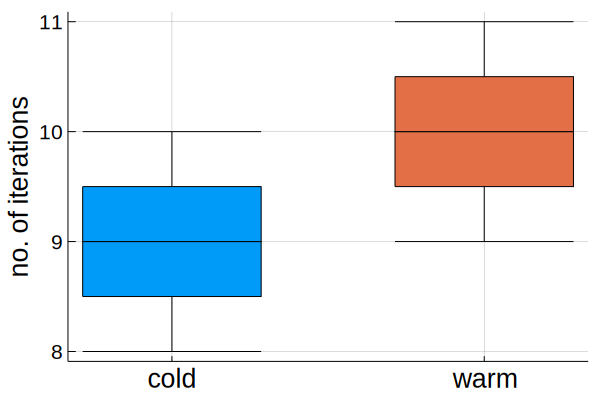

In [40]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_iter
diff_iter[:,2] = warm_iter
@show mean(cold_iter)
@show mean(warm_iter)
@show median(cold_iter)
@show median(warm_iter)

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


mean(diff_iter[:, 1]) = 16.29909683
mean(diff_iter[:, 2]) = 6.9214428245
size(diff_iter) = (2, 2)


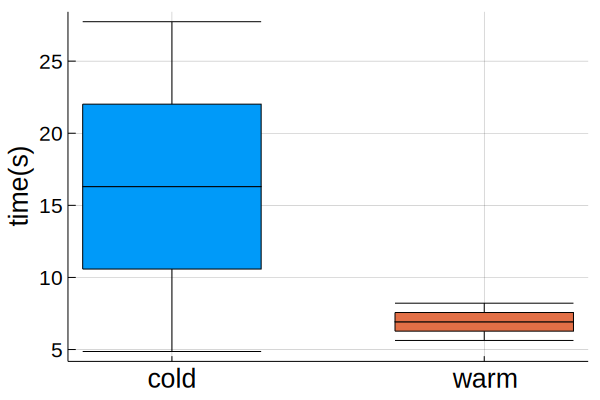

In [41]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_time
diff_iter[:,2] = warm_time
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="time(s)")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [42]:
diff_iter = cold_iter - warm_iter
count(x->x==0.0,diff_iter)
# count(x->x<0.0,diff_iter)

0

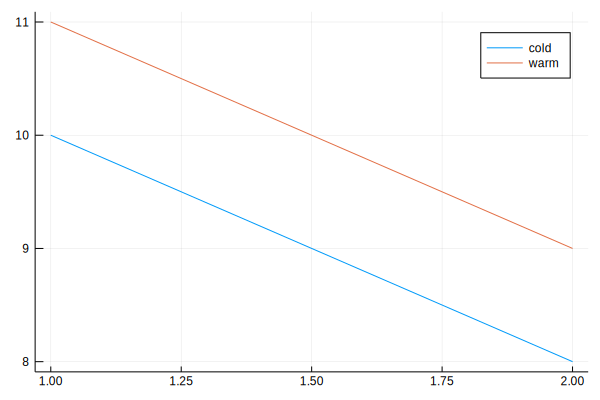

In [43]:
xs = 1:size(w_filt,1)
plot(xs, cold_iter,label="cold")
plot!(xs, warm_iter, label = "warm")


In [44]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (1, 3)
size(c_filt_large_iter) = (1, 3)


(1, 3)

mean(diff_iter[:, 1]) = 10.0
mean(diff_iter[:, 2]) = 11.0
median(diff_iter[:, 1]) = 10.0
median(diff_iter[:, 2]) = 11.0
size(diff_iter) = (1, 2)


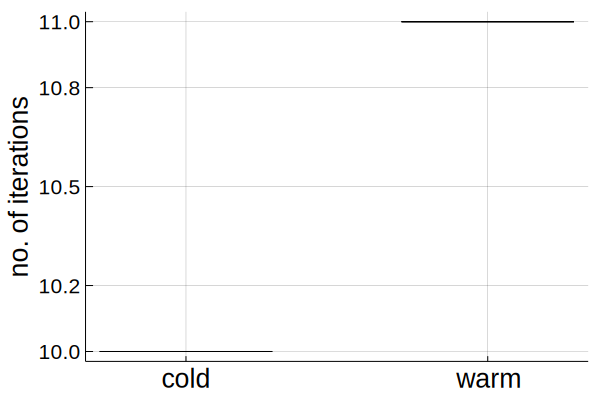

In [45]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [46]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (2, 3)
size(c_filt_large_iter) = (2, 3)


(2, 3)

mean(diff_iter[:, 1]) = 9.0
mean(diff_iter[:, 2]) = 10.0
median(diff_iter[:, 1]) = 9.0
median(diff_iter[:, 2]) = 10.0
size(diff_iter) = (2, 2)


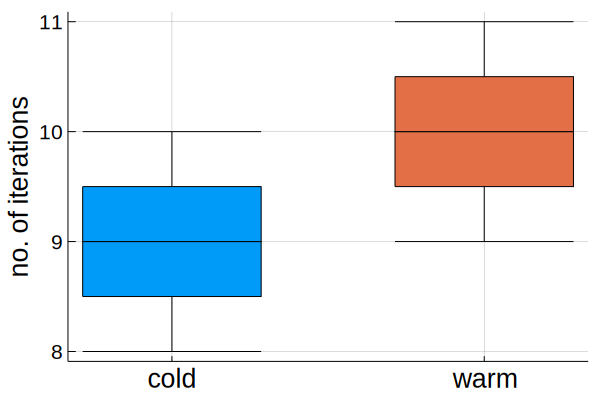

In [47]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")
